In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [0]:
class GatedBlock(tf.keras.Model):
    """"""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_padding = keras.layers.ZeroPadding2D(padding=((kernel_size//2+1, 0),
                                                                    (kernel_size//2, kernel_size//2)))

        self.vertical_conv = keras.layers.Conv2D(filters=2 * filters,
                                                 kernel_size=[kernel_size//2+1, kernel_size],
                                                 strides=1,
                                                 padding='valid')

        self.vertical_cropping = keras.layers.Cropping2D(cropping=((0, 1), (0, 0)))

        self.horizontal_padding = keras.layers.ZeroPadding2D(padding=((0, 0), (kernel_size // 2+1, 0)))
        self.horizontal_conv = keras.layers.Conv2D(filters=2 * filters,
                                                   kernel_size=[1, kernel_size // 2 + 1],
                                                   strides=1,
                                                   padding='valid')
        if mask_type == 'B':
            self.horizontal_cropping = keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))
        elif mask_type == 'A':
            self.horizontal_cropping = keras.layers.Cropping2D(cropping=((0, 0), (0, 1)))

        self.vertical_to_horizontal_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output_conv = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v, h = tf.split(input_tensor, 2, axis=-1)

        vertical_preactivation = self.vertical_padding(v)
        vertical_preactivation = self.vertical_conv(vertical_preactivation)
        vertical_preactivation = self.vertical_cropping(vertical_preactivation)

        horizontal_preactivation = self.horizontal_padding(h)
        horizontal_preactivation = self.horizontal_conv(horizontal_preactivation)
        horizontal_preactivation = self.horizontal_cropping(horizontal_preactivation)

        v_to_h = self.vertical_to_horizontal_conv(vertical_preactivation)  # 1x1
        vertical_output = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        horizontal_activated = self._gate(horizontal_preactivation)

        if self.mask_type =='B':
            horizontal_activated = self.horizontal_output_conv(horizontal_activated)
            horizontal_activated = h + horizontal_activated

        output = tf.concat((vertical_output, horizontal_activated), axis=-1)
        return output


In [0]:
def quantise(images, q_levels):
    """Quantise image into q levels"""
    return (np.digitize(images, np.arange(q_levels) / q_levels) - 1).astype('float32')


def sample_from(distribution):
    """Sample random values from distribution"""
    batch_size, bins = distribution.shape
    return np.array([np.random.choice(bins, p=distr) for distr in distribution])


In [0]:
# --------------------------------------------------------------------------------------------------------------
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)


# --------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)

# --------------------------------------------------------------------------------------------------------------
# Quantise the input data in q levels
q_levels = 16
x_train_quantised = quantise(x_train, q_levels)
x_test_quantised = quantise(x_test, q_levels)


# --------------------------------------------------------------------------------------------------------------
# Creating input stream using tf.data API
batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train_quantised / (q_levels - 1),
                                                    x_train_quantised.astype('int32')))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_quantised / (q_levels - 1),
                                                   x_test_quantised.astype('int32')))
test_dataset = test_dataset.batch(batch_size)


# --------------------------------------------------------------------------------------------------------------
# Create PixelCNN model
# https://github.com/RishabGoel/PixelCNN/blob/master/pixel_cnn.py
# https://github.com/jonathanventura/pixelcnn/blob/master/pixelcnn.py

inputs = keras.layers.Input(shape=(height, width, n_channel))
x = keras.layers.Concatenate()([inputs, inputs])
x = GatedBlock(mask_type='A', filters=64, kernel_size=7)(x)

for i in range(5):
    x = GatedBlock(mask_type='B', filters=64, kernel_size=3)(x)

v, h = tf.split(x, 2, axis=-1)

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=n_channel * q_levels, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

# --------------------------------------------------------------------------------------------------------------
# Prepare optimizer and loss function
lr_decay = 0.9995
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

compute_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)


# --------------------------------------------------------------------------------------------------------------
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)

        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])  # shape [N,H,W,DC] -> [N,H,W,D,C]
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])  # shape [N,H,W,D,C] -> [N,H,W,C,D]

        loss = compute_loss(tf.one_hot(batch_y, q_levels), logits)

    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))

    return loss


In [9]:

# --------------------------------------------------------------------------------------------------------------
# Training loop
n_epochs = 30
n_iter = int(np.ceil(x_train_quantised.shape[0] / batch_size))
for epoch in range(n_epochs):
    start_epoch = time.time()
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay
        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: ITER {:4d}/{:4d} TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter, n_iter,
                                                                                   iter_time,
                                                                                   loss))
    epoch_time = time.time() - start_epoch
    print('EPOCH {:3d}: TIME: {:.2f} ETA: {:.2f}'.format(epoch,
                                                         epoch_time,
                                                         epoch_time * (n_epochs - epoch)))


EPOCH   0: ITER    0/ 469 TIME: 0.01 LOSS: 0.3240
EPOCH   0: ITER  100/ 469 TIME: 0.11 LOSS: 0.3262
EPOCH   0: ITER  200/ 469 TIME: 0.11 LOSS: 0.3175
EPOCH   0: ITER  300/ 469 TIME: 0.11 LOSS: 0.3184
EPOCH   0: ITER  400/ 469 TIME: 0.11 LOSS: 0.3124
EPOCH   0: TIME: 51.02 ETA: 1530.49
EPOCH   1: ITER    0/ 469 TIME: 0.01 LOSS: 0.3265
EPOCH   1: ITER  100/ 469 TIME: 0.11 LOSS: 0.3174
EPOCH   1: ITER  200/ 469 TIME: 0.10 LOSS: 0.3187
EPOCH   1: ITER  300/ 469 TIME: 0.10 LOSS: 0.3164
EPOCH   1: ITER  400/ 469 TIME: 0.10 LOSS: 0.3276
EPOCH   1: TIME: 51.00 ETA: 1479.12
EPOCH   2: ITER    0/ 469 TIME: 0.01 LOSS: 0.3171
EPOCH   2: ITER  100/ 469 TIME: 0.11 LOSS: 0.3159
EPOCH   2: ITER  200/ 469 TIME: 0.11 LOSS: 0.3218
EPOCH   2: ITER  300/ 469 TIME: 0.11 LOSS: 0.3229
EPOCH   2: ITER  400/ 469 TIME: 0.11 LOSS: 0.3082
EPOCH   2: TIME: 51.01 ETA: 1428.30
EPOCH   3: ITER    0/ 469 TIME: 0.01 LOSS: 0.3214
EPOCH   3: ITER  100/ 469 TIME: 0.11 LOSS: 0.3177
EPOCH   3: ITER  200/ 469 TIME: 0.11 LOSS:

In [0]:
# --------------------------------------------------------------------------------------------------------------
# Generating new images
samples = np.zeros((100, height, width, n_channel), dtype='float32')
for i in range(28):
    for j in range(28):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)


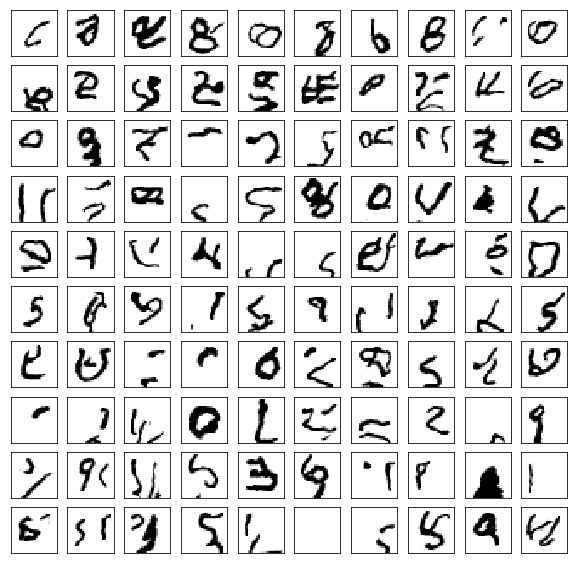

In [11]:

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()



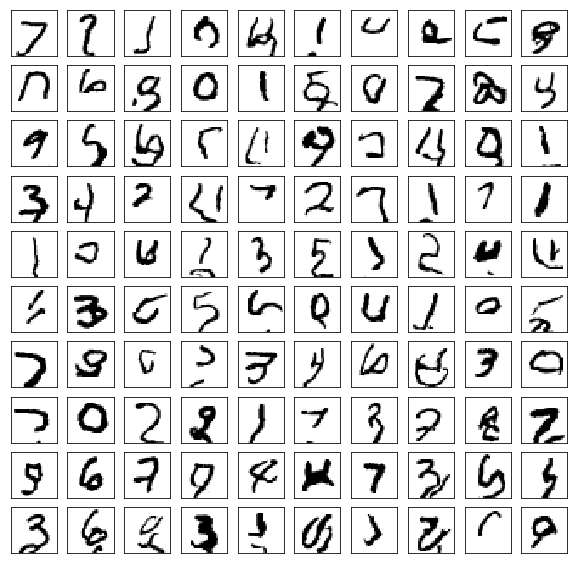

In [12]:

# --------------------------------------------------------------------------------------------------------------
# Filling occluded images
occlude_start_row = 14
num_generated_images = 100
samples = np.copy(x_test_quantised[0:num_generated_images, :, :, :])
samples = samples / (q_levels - 1)
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(samples)
        logits = tf.reshape(logits, [-1, height, width, q_levels, n_channel])
        logits = tf.transpose(logits, perm=[0, 1, 2, 4, 3])
        probs = tf.nn.softmax(logits)
        next_sample = probs[:, i, j, 0, :]
        samples[:, i, j, 0] = sample_from(next_sample.numpy()) / (q_levels - 1)

fig = plt.figure(figsize=(10, 10))
for i in range(100):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()
